In [4]:
# ------------------------------------------
# a. Import Required Libraries
# ------------------------------------------
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, UpSampling2D, Dense
from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt

In [5]:
# -------------------------
# b. Load and Preprocess Data
# -------------------------
# CIFAR10 contains 10 classes, each image is 32x32x3
(x_train, _), (x_test, _) = cifar10.load_data()

In [6]:
# Normalize and add channel dimension
# Normalize between 0 and 1
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

In [7]:
# ------------------------------------------
# c. Build Encoder
# ------------------------------------------
input_img = Input(shape=(32, 32, 3))

# Encoder architecture
x =  Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x =  MaxPooling2D((2, 2), padding='same')(x)

x =  Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x =  MaxPooling2D((2, 2), padding='same')(x)

# Latent representation
latent =  Conv2D(128, (3, 3), activation='relu', padding='same')(x)

encoder = Model(input_img, latent, name="encoder")


In [8]:
# ------------------------------------------
# d. Build Decoder
# ------------------------------------------
decoder_input =  Input(shape=(8, 8, 128))

y =  Conv2D(64, (3, 3), activation='relu', padding='same')(decoder_input)
y =  UpSampling2D((2, 2))(y)

y =  Conv2D(32, (3, 3), activation='relu', padding='same')(y)
y =  UpSampling2D((2, 2))(y)

# Output layer
decoded =  Conv2D(3, (3, 3), activation='sigmoid', padding='same')(y)

decoder = Model(decoder_input, decoded, name="decoder")


In [9]:
# ------------------------------------------
# e. Combine Encoder and Decoder into Autoencoder
# ------------------------------------------
autoencoder_input = input_img
encoded_img = encoder(autoencoder_input)
decoded_img = decoder(encoded_img)

autoencoder = Model(autoencoder_input, decoded_img, name="autoencoder")

In [10]:
# Compile model
autoencoder.compile(
    optimizer='adam',
    loss='mse',               # reconstruction error
    metrics=['accuracy']
)


In [11]:
# ------------------------------------------
# Train Autoencoder
# ------------------------------------------
history = autoencoder.fit(
    x_train,
    x_train,
    epochs=10,
    batch_size=128,
    shuffle=True,
    validation_data=(x_test, x_test)
)

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 31s 77ms/step - accuracy: 0.6075 - loss: 0.0207 - val_accuracy: 0.7466 - val_loss: 0.0056
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 32s 83ms/step - accuracy: 0.7759 - loss: 0.0051 - val_accuracy: 0.7972 - val_loss: 0.0042
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 35s 91ms/step - accuracy: 0.7931 - loss: 0.0042 - val_accuracy: 0.8016 - val_loss: 0.0038
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 36s 92ms/step - accuracy: 0.8017 - loss: 0.0038 - val_accuracy: 0.8129 - val_loss: 0.0036
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 36s 92ms/step - accuracy: 0.8041 - loss: 0.0035 - val_accuracy: 0.7985 - val_loss: 0.0033
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 37s 94ms/step - accuracy: 0.8047 - loss: 0.0034 - val_accuracy: 0.8144 - val_loss: 0.0033
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 37s 94ms/step - accuracy: 0.8098 - loss: 0.0032 - val_accuracy: 0.7846 - val_loss: 0.0031
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 37s 95ms/step - accuracy: 0.8116 - loss: 0.0029 - 

In [12]:
# ------------------------------------------
# Anomaly Detection
# ------------------------------------------
# Reconstruct test images
reconstructed = autoencoder.predict(x_test)


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


In [20]:
# Compute per-image reconstruction error (MAE)
reconstruction_error = np.mean(np.abs(x_test - reconstructed))

# Define threshold (95 percentile of normal samples)
threshold = np.percentile(reconstruction_error, 95)

print("Anomaly threshold:", threshold)

loss = np.mean((x_test - reconstructed)**2)
print("MSA: ", loss)

Anomaly threshold: 0.035535041242837906
MSA:  0.0024791807


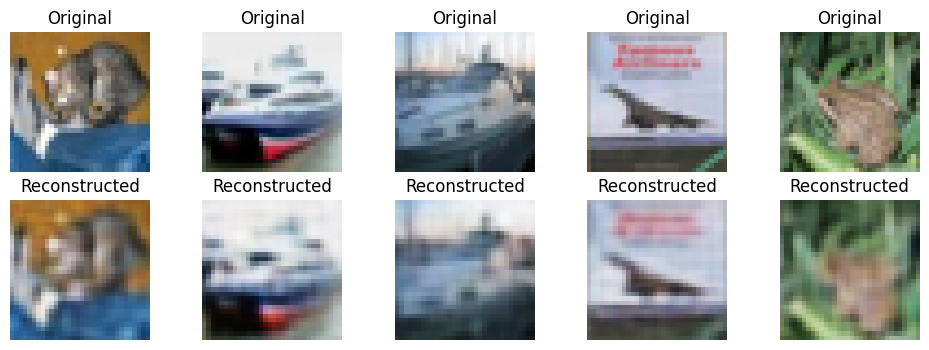

In [17]:
# ------------------------------------------
# Visualize Original vs Reconstructed
# ------------------------------------------
plt.figure(figsize=(12, 4))
for i in range(5):
    # Original
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(x_test[i])
    plt.title("Original")
    plt.axis("off")

    # Reconstructed
    ax = plt.subplot(2, 5, i + 1 + 5)
    plt.imshow(reconstructed[i])
    plt.title("Reconstructed")
    plt.axis("off")

plt.show()